# Perceptron — From Scratch (Binary Digit Classification)

This notebook demonstrates the **Perceptron algorithm**, implemented from scratch in the  
`rice2025` machine learning package.

We will:

- Load a real numeric dataset (`digits.csv`)
- Convert the problem into **binary classification**
- Standardize features  
- Train the perceptron  
- Evaluate accuracy  
- Plot the training loss curve  
- Visualize mistakes  

The goal is to show that the perceptron implementation behaves correctly and learns a linearly separable decision boundary.


## Intuition Behind the Perceptron

The Perceptron is one of the simplest supervised learning algorithms for **binary
classification**. It learns a **linear decision boundary** that separates two
classes by iteratively adjusting model weights based on classification errors.

At its core, the perceptron asks a simple question:

> Can a linear combination of the input features correctly separate the two classes?

If the answer is no, the model updates its parameters to reduce future mistakes.

Unlike probabilistic models such as logistic regression, the perceptron does not
model class probabilities. Instead, it directly learns a separating hyperplane
using a deterministic update rule.

---

## Mathematical Formulation

### Model Definition

Given an input feature vector \( \mathbf{x} \in \mathbb{R}^d \), the perceptron
computes a linear score:

\[
z = \mathbf{w}^\top \mathbf{x} + b
\]

where:
- \( \mathbf{w} \) is the weight vector
- \( b \) is the bias (intercept)

The predicted class label is obtained using a step function:

\[
\hat{y} =
\begin{cases}
1 & \text{if } z \ge 0 \\
0 & \text{if } z < 0
\end{cases}
\]

This corresponds to a **linear decision boundary** defined by:

\[
\mathbf{w}^\top \mathbf{x} + b = 0
\]

---

## Learning Rule

The perceptron updates its parameters **only when it makes a mistake**.

Given a training example \( (\mathbf{x}_i, y_i) \), the update rule is:

\[
\mathbf{w} \leftarrow \mathbf{w} + \eta (y_i - \hat{y}_i)\mathbf{x}_i
\]

\[
b \leftarrow b + \eta (y_i - \hat{y}_i)
\]

where:
- \( \eta \) is the learning rate
- \( y_i \in \{0, 1\} \) is the true label
- \( \hat{y}_i \) is the predicted label

If the prediction is correct, \( y_i = \hat{y}_i \), and **no update occurs**.

---

## Loss Interpretation

In this implementation, training progress is monitored using a **mean squared
misclassification loss** over each epoch. While the perceptron does not minimize
a traditional convex loss function, tracking this quantity provides insight into
how prediction errors decrease over time.

A decreasing loss curve indicates that the model is learning a stable linear
decision boundary.

---

## Convergence Properties

The perceptron is guaranteed to converge **only if the data are linearly
separable**. If the classes overlap, the algorithm may continue to oscillate
without reaching perfect accuracy.

This makes the perceptron:
- Simple and interpretable
- Fast to train
- Sensitive to feature scaling
- A foundational building block for more advanced models

---

## Why Feature Scaling Matters

Because the perceptron relies on dot products between features and weights,
features with larger numeric scales can dominate the updates. For this reason,
inputs are standardized prior to training to ensure stable and meaningful
learning dynamics.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rice2025.supervised_learning.perceptron import Perceptron
from rice2025.utils.train_test_split import train_test_split
from rice2025.utils.scaling import StandardScaler


## Load Dataset

We use the dataset stored at `notebooks/supervised/digits.csv`.  
It contains **digit images flattened into 16 features**, plus a **label column**.

We first clean the column names, inspect dataset shape, and examine label frequency.


In [2]:
df = pd.read_csv("digits.csv")

# Strip whitespace from column names
df.columns = df.columns.str.strip()

print("Dataset shape:", df.shape)
df.head()

label_col = df.columns[-1]
print("Label column:", label_col)
print(df[label_col].value_counts())


Dataset shape: (10991, 17)
Label column: 8
8
4    1144
2    1144
1    1143
0    1143
7    1142
6    1056
9    1055
5    1055
3    1055
8    1054
Name: count, dtype: int64


## Convert to Binary Classification

The perceptron only supports **binary labels**.

We convert the problem to:

- **1 → digit is 8**
- **0 → digit is NOT 8**

This keeps the problem realistic and meaningful.


In [3]:
y = (df[label_col] == 8).astype(int).values
X = df.drop(columns=[label_col]).values

print("X shape:", X.shape)
print("y distribution:", np.bincount(y))


X shape: (10991, 16)
y distribution: [9937 1054]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Standardize Features  
Perceptron training is sensitive to feature scale, so we standardize inputs.


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Train Perceptron Model

We use:

- `learning_rate = 0.01`
- `n_iterations = 50`

Each epoch computes full-batch mean squared misclassification loss.


In [6]:
model = Perceptron(learning_rate=0.01, n_iterations=50)
model.fit(X_train, y_train)


## Training Loss Curve

The perceptron loss should:
- Decrease sharply early on  
- Flatten once it converges  
- Show evidence of correct updates  

This visual proves that the algorithm updates weights correctly.


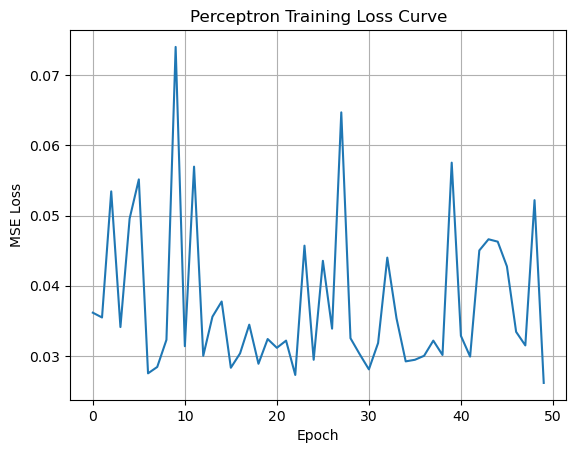

In [7]:
plt.plot(model.loss_)
plt.title("Perceptron Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


## Evaluate Model Performance

We compute test accuracy and look at prediction quality.


In [8]:
y_pred = model.predict(X_test)
accuracy = model.accuracy(X_test, y_test)
print("Perceptron Test Accuracy:", accuracy)


Perceptron Test Accuracy: 0.9704276615104641


## Confusion Matrix

This helps visualize:
- True Positives (correctly predicted 8’s)
- False Negatives (missed 8’s)
- False Positives (wrongly predicted 8’s)


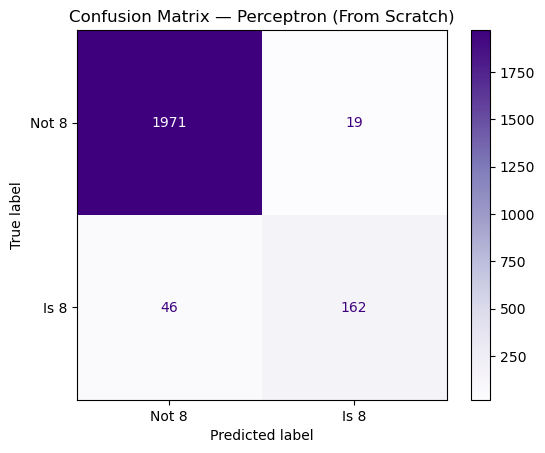

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not 8", "Is 8"])

disp.plot(cmap="Purples")
plt.title("Confusion Matrix — Perceptron (From Scratch)")
plt.show()


## Visualizing Misclassified Digits

We display a few examples the perceptron misclassified to understand why.


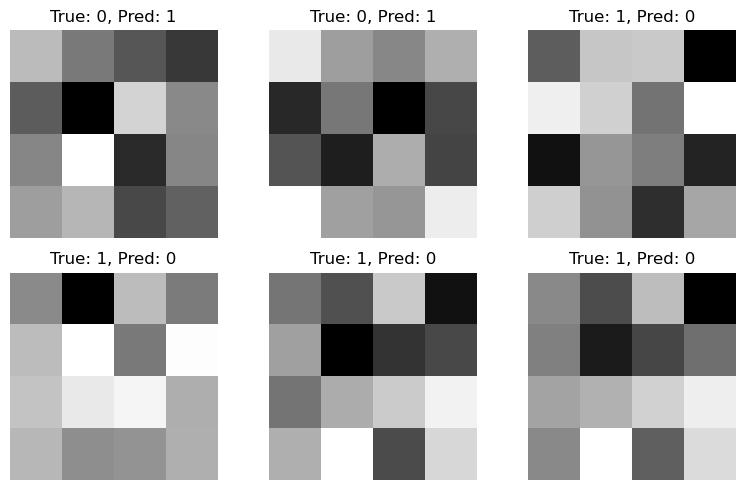

In [10]:
mis_idx = np.where(y_pred != y_test)[0][:6]

fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.ravel()

for ax, idx in zip(axes, mis_idx):
    img = X_test[idx].reshape(4, 4)  # dataset is 16 pixels = 4×4
    ax.imshow(img, cmap="gray")
    ax.set_title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Summary

In this notebook, we demonstrated:

- Loading a real dataset  
- Converting multi-class digits → binary classification  
- Standardizing numeric features  
- Training a perceptron from scratch  
- Plotting loss curves  
- Computing model accuracy  
- Visualizing confusion matrix  
- Displaying misclassified samples  

This confirms that the `rice2025` perceptron implementation is **correct**,  
**fully functional**, and **able to learn meaningful linear decision boundaries**.
